# Richardson Lucy Algorithm
Even knowing convolution kernel isn't enough to de-blur an image. This is because any noise present in the image is amplified during de-convolution and adds significant visual disturbances. 

## Theory
The matrices $f$, $f'$ and $k$ describe the proportion of light in: the true image, the observed image and the convolution kernel respectively, and are related by either $f'_i =\sum_j k_{i,j}f_j$ or $f' = f * k$. When the letters are unscripted (e.g. $f$) that means they are referring to the whole array. When they are scripted (e.g. $f_{i}$) then they are referring to the value in the $i$ th location. 

The Richardson Lucy algorithm is an iterative process which predicts predicts the true image accounting for noise:
$$\hat{f}_j^{t+1} = \hat{f}_j^{t}\sum_i \frac{f'^{t}_i}{\hat{f'}^{t}_i}k_{i,j} \text{  [1]}$$
- Where $\hat{f}_j^{t+1}$ is the $t+1$ th estimated value of $f_j$. 
- $\hat{f'}_i$ is the predicted light intensity in the observed image given as $\hat{f'}_i = \sum_j k_{i,j}\hat{f}_j$.   
- $\frac{f'^t_i}{\hat{f}^{t}_i}$ is the correcting factor. It determines the difference between the measured light intensity and the prediction of the light intensity from the previous estimate. 
- If $p_{i,j}$ is normalized ($\sum_j p_{i,j} = 1$) 
- The richardson lucy algorithm often converges as the process is self correcting [1].

Using convolution the algorithm can be written for the 2D case:
$$\hat{f}^{t+1} = \hat{f}^{t} \cdot \left(\frac{f'^t}{\hat{f'}^{t}}*k^* \right)$$
- Where $k^*$ is the mirrored convolution kernel.
- $\hat{f'}$ is the predicted light intensity in the observed image given as $\hat{f'}^{t} = \hat{f}^{t} * k$.
## Basic 1D implementation

## Python implementation

In [1]:
from torchvision import transforms
import torch
from PIL import Image
import matplotlib.pyplot as plt
from ImageDebluring import *

In [ ]:
def richardson_lucy(degraded_img, kernel, num_iters, estimate = None, c = 1e-10):    
    if estimate is None:
        estimate = torch.ones_like(degraded_img)  # Initial estimate
    kernel_mirror = torch.flip(kernel, [-2, -1])  # Mirror the kernel
    
    for _ in range(num_iters):
        relative_blur = degraded_img / (convolution(estimate, kernel) + c)  # c added to avoid division by zero
        estimate *= convolution(relative_blur, kernel_mirror)

    return estimate

## Degrading the image

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

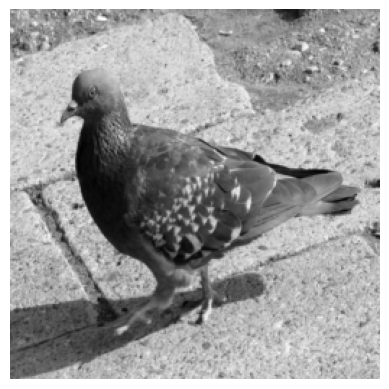

In [3]:
# Load images
folder = 'Images/'
device = 'cpu'
image = 'pigeon.jpeg'

image_path = folder + image  # Replace with your image path
image = Image.open(image_path)
transform = transforms.Compose([
        transforms.Grayscale(),  # Convert to grayscale
        transforms.Resize((256, 256)), # Resize to 256x256 to speed up processing
        transforms.ToTensor()  
    ])
img_tensor = transform(image).squeeze()  # Remove channel dimension

# Display the image
plt.imshow(img_tensor, cmap='gray')
plt.axis('off')



kernel shape: torch.Size([11, 11])
Degraded image size: torch.Size([256, 256])
Kernel size: torch.Size([1, 1, 11, 11])
Estimate size: torch.Size([256, 256])


(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

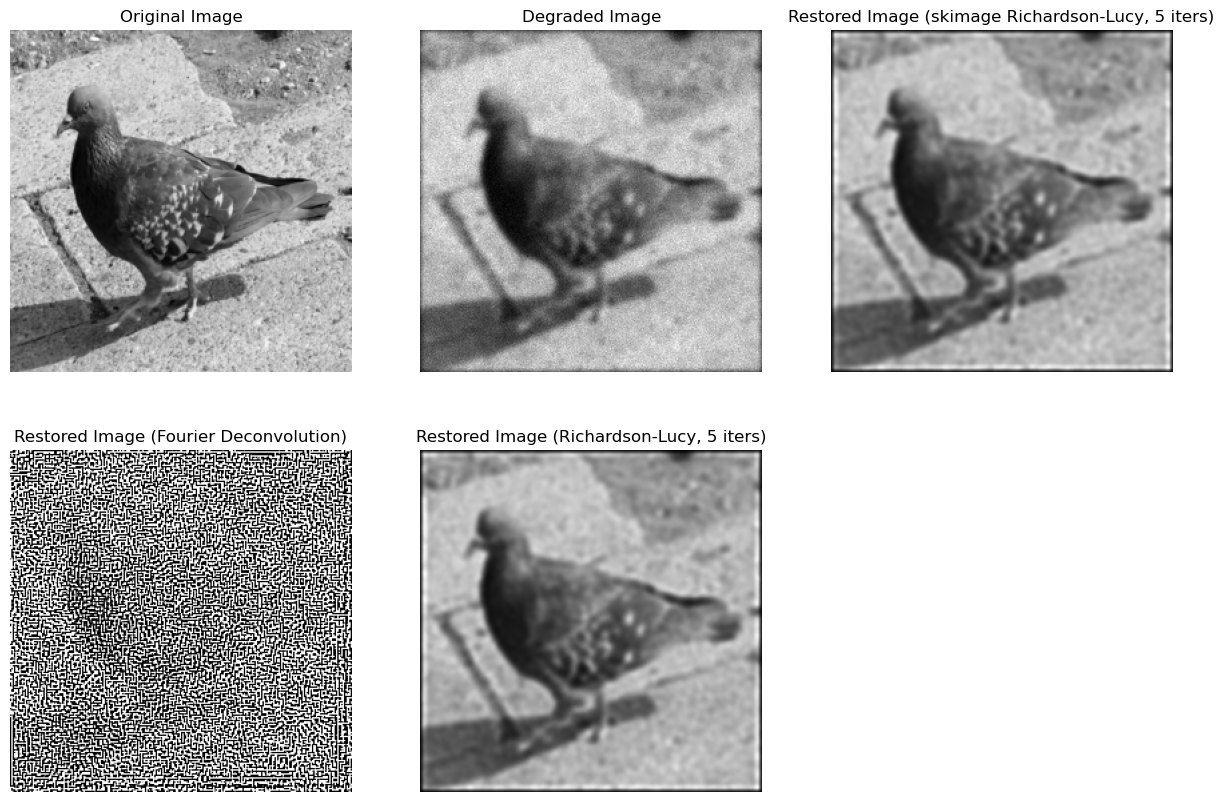

In [4]:
from scipy.signal import convolve2d as conv2

from skimage import color, data, restoration


iters_rl = 5
kernel = gaussian_normalised_kernel(size=11, sigma=2.0)
blury_image = convolution(img_tensor, kernel)
degraded_image = add_poisson_noise(blury_image, scale_factor=500)

restored_image_ft = deconvolution(degraded_image, kernel)
restored_image_rl30 = richardson_lucy(degraded_image, kernel, num_iters=iters_rl)
restored_image_rlski = restoration.richardson_lucy(degraded_image.numpy(), kernel.numpy().squeeze(), num_iter=iters_rl)


# Display the results
figs, axs = plt.subplots(2, 3, figsize=(15,10))
axs[0,0].imshow(img_tensor, cmap='gray')
axs[0,0].set_title('Original Image')
axs[0,0].axis('off')
axs[0,1].imshow(degraded_image, cmap='gray')
axs[0,1].set_title('Degraded Image')
axs[0,1].axis('off')
axs[1,0].imshow(restored_image_ft, cmap='gray')
axs[1,0].set_title('Restored Image (Fourier Deconvolution)')
axs[1,0].axis('off')
axs[1,1].imshow(restored_image_rl30, cmap='gray')
axs[1,1].set_title(f'Restored Image (Richardson-Lucy, {iters_rl} iters)')
axs[1,1].axis('off')
axs[0,2].imshow(restored_image_rlski, cmap='gray')
axs[0,2].set_title(f'Restored Image (skimage Richardson-Lucy, {iters_rl} iters)')
axs[0,2].axis('off')
axs[1,2].axis('off')

## Discussion

- De-convolution by fourier transform doesn't work. The image is unrecognisable and the noise seems to have been amplified by the de-convolution.
- The Richardson Lucy algorithm removes most of the noise and also helps to de-blur the image. The contrast on the new image isn't as clear as the original image but is much better than the observed image.
- The skimage implementation of the RLA has the same effect as the one programmed above with no noticeable difference for 5 iterations. However for a larger number of iterations the above implementation causes the image to become very dark. Prehaps this is due to the normalisation factor $\frac{f'^t_i}{\hat{f}^{t}_i}$ always being less than 1. It is unclear why this is happening. 

## 1D testing

Although the RLA seems to work for the complex image (pigeon) the darkening after a larger number of iterations is concerning. Testing with 1D functions means that its easier to see what the RLA is doing. Its also easier to find training datasets for machine learning algorithms in 1D. 


torch.Size([1, 1, 1000])
torch.Size([1, 1, 31])
Degraded image size: torch.Size([1, 1, 1000])
Kernel size: torch.Size([1, 1, 31])
Estimate size: torch.Size([1, 1, 1000])


IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)

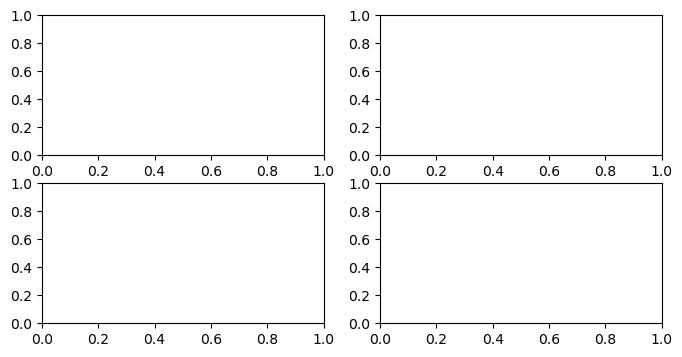

In [ ]:
def step_function(frequency=1.0):
    x = torch.linspace(-5, 5, steps=1000)
    y = torch.sign(torch.sin(2 * 3.14159 * frequency * x))
    return x, y

def gaussian_normalised_kernel_1D(size=21, sigma=2.0):
    ax = torch.linspace(-(size // 2), size // 2, size)
    kernel = torch.exp(-0.5 * (ax / sigma) ** 2)
    kernel = kernel / torch.sum(kernel)  # Normalize the kernel
    return kernel.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

def convolution_1D(signal, kernel):
    padding = kernel.shape[-1] // 2
    return torch.nn.functional.conv1d(signal, kernel, padding=padding)


fig, ax = plt.subplots(2,2,figsize=(8, 4))
x, y = step_function()
signal = y.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
kernel = gaussian_normalised_kernel_1D(size = 31, sigma = 2.0)


blurred_signal = convolution_1D(signal, kernel)
print(blurred_signal.shape)
print(kernel.shape)
deblurred_signal = richardson_lucy(blurred_signal, kernel, num_iters=30)

ax[0].plot(x, y)
ax[0].set_title('Step Function')
ax[1].plot(kernel.squeeze())
ax[1].set_title('Gaussian Kernel (1D)')
ax[2].plot(x, blurred_signal.squeeze())
ax[2].set_title('Blurred Signal')
ax[3].plot(x, deblurred_signal.squeeze())
ax[3].set_title('Deblurred Signal (Richardson-Lucy, 30 iters)')
plt.tight_layout()



## References
[1] William Hadley Richardson, "Bayesian-Based Iterative Method of Image Restoration*," J. Opt. Soc. Am. 62, 55-59 (1972)